## LR scheudlers: SimpleWarmUpAndDecay


Using TensorFlow version: 2.10.1
--- Scenario 1: Starting from Step 0 ---
tf.Tensor(1.0, shape=(), dtype=float32)
LR at step 0 (effective step 0): 1.000000e-05
tf.Tensor(1.0, shape=(), dtype=float32)
LR at step 1000 (effective step 1000): 5.050001e-04
tf.Tensor(1.0, shape=(), dtype=float32)
LR at step 2000 (effective step 2000): 1.000000e-03
tf.Tensor(0.0, shape=(), dtype=float32)
LR at step 5000 (effective step 5000): 6.916504e-04

--- Scenario 2: Resuming from Step 3000 ---
tf.Tensor(0.0, shape=(), dtype=float32)
LR at step 0 *since resume* (effective step 3000): 9.619779e-04
tf.Tensor(0.0, shape=(), dtype=float32)
LR at step 1000 *since resume* (effective step 4000): 8.536999e-04
tf.Tensor(0.0, shape=(), dtype=float32)
LR check using scheduler 1 at absolute step 3000: 9.619779e-04
tf.Tensor(0.0, shape=(), dtype=float32)
LR check using scheduler 1 at absolute step 4000: 8.536999e-04
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(7000,), dtype=float32)
tf.Tensor([1. 1. 1. ... 0. 0. 0.], sh

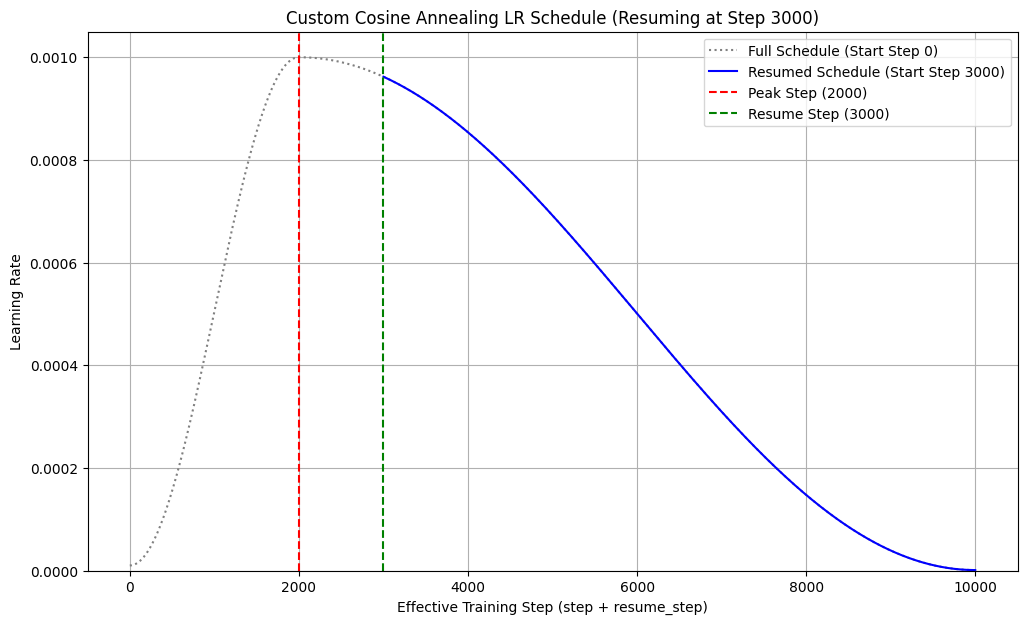

In [8]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt # Optional: for plotting the schedule

# Ensure TensorFlow version is compatible (check >= 2.x, user specified 2.10)
print(f"Using TensorFlow version: {tf.__version__}")

class CosineAnnealingWarmupRestartsResumable(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Custom Learning Rate Scheduler with Resumption Capability.

    Implements a schedule that first increases the learning rate from start_lr
    to peak_lr using a cosine function over peak_step steps, and then
    decreases the learning rate from peak_lr to final_lr using a cosine
    function over the remaining steps (total_steps - peak_step).

    Includes a `resume_step` parameter to correctly calculate the LR when
    resuming training from an intermediate step.
    """

    def __init__(self, total_steps, start_lr, peak_lr, final_lr, peak_step, resume_step=0, name=None):
        """
        Initializes the scheduler.

        Args:
            total_steps (int): The total number of training steps for the entire training run.
            start_lr (float): The initial learning rate at step 0.
            peak_lr (float): The maximum learning rate, reached at peak_step.
            final_lr (float): The final learning rate at total_steps.
            peak_step (int): The step at which the learning rate reaches peak_lr
                               (relative to the start, step 0). Must be less than total_steps.
            resume_step (int, optional): The step number from which to resume the schedule.
                                         Defaults to 0 (starts from the beginning).
                                         The optimizer's internal step counter should typically
                                         start from 0 when resuming, and this `resume_step`
                                         offsets the calculation.
            name (str, optional): Optional name for the schedule. Defaults to None.

        Raises:
            ValueError: If parameters are invalid (e.g., peak_step >= total_steps, negative values).
        """
        super(CosineAnnealingWarmupRestartsResumable, self).__init__()

        # --- Validation ---
        if not isinstance(total_steps, (int, tf.Tensor)) or total_steps <= 0:
             raise ValueError("total_steps must be a positive integer.")
        if not isinstance(peak_step, (int, tf.Tensor)) or peak_step < 0 :
             raise ValueError("peak_step must be a non-negative integer.")
        if peak_step >= total_steps:
            raise ValueError(f"peak_step ({peak_step}) must be less than "
                             f"total_steps ({total_steps}).")
        if not all(isinstance(lr, (float, int, tf.Tensor)) and lr >= 0 for lr in [start_lr, peak_lr, final_lr]):
             raise ValueError("Learning rates (start_lr, peak_lr, final_lr) must be non-negative numbers.")
        if not isinstance(resume_step, (int, tf.Tensor)) or resume_step < 0:
            raise ValueError("resume_step must be a non-negative integer.")
        if resume_step >= total_steps:
             print(f"Warning: resume_step ({resume_step}) is >= total_steps ({total_steps}). "
                   f"LR will likely stay at final_lr.")
        # --- End Validation ---


        self.total_steps = tf.cast(total_steps, tf.float32)
        self.start_lr = tf.cast(start_lr, tf.float32)
        self.peak_lr = tf.cast(peak_lr, tf.float32)
        self.final_lr = tf.cast(final_lr, tf.float32)
        self.peak_step = tf.cast(peak_step, tf.float32) # Absolute step for the peak
        self.resume_step = tf.cast(resume_step, tf.float32)
        self.pi = tf.constant(math.pi, dtype=tf.float32)
        self.name = name

        # Calculate steps for each phase relative to absolute step 0
        self.warmup_steps = self.peak_step
        # Ensure decay_steps is at least 1 to avoid division by zero if peak_step = total_steps - 1
        self.decay_steps = tf.maximum(self.total_steps - self.peak_step, 1.0)


    def __call__(self, step):
        """
        Calculates the learning rate for a given step since training/resumption started.

        Args:
            step (tf.Tensor or int): The current training step count *since the
                                     start of the current training run* (0-indexed).
                                     Typically the optimizer's iteration count.

        Returns:
            tf.Tensor: The calculated learning rate for the given effective step.
        """
        step = tf.cast(step, dtype=tf.float32)
        # Calculate the effective step in the *overall* schedule
        effective_step = step + self.resume_step

        # Ensure effective_step doesn't exceed total_steps for calculation purposes
        effective_step = tf.minimum(effective_step, self.total_steps -1)

        # Define the computation for the warmup (increasing) phase based on effective_step
        def warmup_lr():
            # Cosine annealing from start_lr to peak_lr
            # Formula: start + 0.5 * (peak - start) * (1 - cos(pi * progress))
            progress = effective_step / self.warmup_steps
            # Clamp progress just in case effective_step slightly exceeds warmup_steps due to float math
            progress = tf.minimum(progress, 1.0)
            return self.start_lr + 0.5 * (self.peak_lr - self.start_lr) * \
                   (1.0 - tf.cos(self.pi * progress))

        # Define the computation for the decay (decreasing) phase based on effective_step
        def decay_lr():
            # Cosine annealing from peak_lr to final_lr
            # Formula: final + 0.5 * (peak - final) * (1 + cos(pi * progress))
            # Calculate progress within the decay phase (relative to peak_step)
            steps_into_decay = effective_step - self.peak_step
            progress = tf.minimum(1.0, steps_into_decay / self.decay_steps) # Clip progress to max 1.0
            # Ensure progress isn't negative if effective_step < peak_step (shouldn't happen with outer tf.cond, but safe)
            progress = tf.maximum(0.0, progress)
            return self.final_lr + 0.5 * (self.peak_lr - self.final_lr) * \
                   (1.0 + tf.cos(self.pi * progress))
        
        is_warmup = tf.cast(effective_step <= self.peak_step, dtype = tf.float32)
        # Use tf.cond to switch between warmup and decay based on the *effective_step*
        # relative to the absolute peak_step
        print(is_warmup)
        learning_rate = is_warmup* warmup_lr() + (1.0-is_warmup)*decay_lr()

        return learning_rate


    def get_config(self):
        """Returns the configuration of the scheduler."""
        # Use .numpy() to get Python native types for serialization if they are Tensors
        config = {
            "total_steps": int(self.total_steps.numpy()) if hasattr(self.total_steps, 'numpy') else self.total_steps,
            "start_lr": float(self.start_lr.numpy()) if hasattr(self.start_lr, 'numpy') else self.start_lr,
            "peak_lr": float(self.peak_lr.numpy()) if hasattr(self.peak_lr, 'numpy') else self.peak_lr,
            "final_lr": float(self.final_lr.numpy()) if hasattr(self.final_lr, 'numpy') else self.final_lr,
            "peak_step": int(self.peak_step.numpy()) if hasattr(self.peak_step, 'numpy') else self.peak_step,
            "resume_step": int(self.resume_step.numpy()) if hasattr(self.resume_step, 'numpy') else self.resume_step,
            "name": self.name,
        }
        # Filter out None values if name wasn't provided
        return {k: v for k, v in config.items() if v is not None}

# --- Example Usage ---

# 1. Define Parameters (same total schedule as before)
TOTAL_STEPS = 10000
START_LR = 1e-5
PEAK_LR = 1e-3
FINAL_LR = 1e-6
PEAK_STEP = 2000 # Absolute step where peak LR occurs

# --- Scenario 1: Starting from scratch ---
print("--- Scenario 1: Starting from Step 0 ---")
RESUME_STEP_1 = 0
lr_scheduler_1 = CosineAnnealingWarmupRestartsResumable(
    total_steps=TOTAL_STEPS,
    start_lr=START_LR,
    peak_lr=PEAK_LR,
    final_lr=FINAL_LR,
    peak_step=PEAK_STEP,
    resume_step=RESUME_STEP_1
)
optimizer_1 = tf.keras.optimizers.Adam(learning_rate=lr_scheduler_1)

print(f"LR at step 0 (effective step {RESUME_STEP_1 + 0}): {lr_scheduler_1(0).numpy():.6e}")
print(f"LR at step 1000 (effective step {RESUME_STEP_1 + 1000}): {lr_scheduler_1(1000).numpy():.6e}")
print(f"LR at step {PEAK_STEP} (effective step {RESUME_STEP_1 + PEAK_STEP}): {lr_scheduler_1(PEAK_STEP).numpy():.6e}")
print(f"LR at step 5000 (effective step {RESUME_STEP_1 + 5000}): {lr_scheduler_1(5000).numpy():.6e}")

# --- Scenario 2: Resuming training after 3000 steps ---
print("\n--- Scenario 2: Resuming from Step 3000 ---")
RESUME_STEP_2 = 3000
lr_scheduler_2 = CosineAnnealingWarmupRestartsResumable(
    total_steps=TOTAL_STEPS,
    start_lr=START_LR,
    peak_lr=PEAK_LR,
    final_lr=FINAL_LR,
    peak_step=PEAK_STEP,
    resume_step=RESUME_STEP_2 # Critical: Tell scheduler where we are resuming from
)
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=lr_scheduler_2)
# IMPORTANT: When resuming, the optimizer's internal step count often resets or
# needs to be manually set. The 'step' passed to lr_scheduler_2(step)
# should represent steps *since resumption*.

# Calculate LR for the first step *after* resuming (step=0 passed to scheduler)
# This corresponds to the overall schedule's step 3000
print(f"LR at step 0 *since resume* (effective step {RESUME_STEP_2 + 0}): {lr_scheduler_2(0).numpy():.6e}")

# Calculate LR for the 1000th step *after* resuming (step=1000 passed to scheduler)
# This corresponds to the overall schedule's step 4000
print(f"LR at step 1000 *since resume* (effective step {RESUME_STEP_2 + 1000}): {lr_scheduler_2(1000).numpy():.6e}")

# Compare: Calculate LR at absolute step 3000 and 4000 using the first scheduler
print(f"LR check using scheduler 1 at absolute step 3000: {lr_scheduler_1(3000).numpy():.6e}")
print(f"LR check using scheduler 1 at absolute step 4000: {lr_scheduler_1(4000).numpy():.6e}")
# The results should match the resumed scheduler's outputs above.

# --- (Optional) Plotting the resumed schedule ---
steps_since_resume = tf.range(TOTAL_STEPS - RESUME_STEP_2, dtype=tf.float32)
lrs_resumed = lr_scheduler_2(steps_since_resume)
effective_steps_plot = steps_since_resume + RESUME_STEP_2

plt.figure(figsize=(12, 7))

# Plot the full schedule for reference (using scheduler 1)
full_steps = tf.range(TOTAL_STEPS, dtype=tf.float32)
full_lrs = lr_scheduler_1(full_steps)
plt.plot(full_steps.numpy(), full_lrs.numpy(), label='Full Schedule (Start Step 0)', color='grey', linestyle=':')

# Plot the schedule as calculated by the resumed scheduler
plt.plot(effective_steps_plot.numpy(), lrs_resumed.numpy(), label=f'Resumed Schedule (Start Step {RESUME_STEP_2})', color='blue')

plt.xlabel("Effective Training Step (step + resume_step)")
plt.ylabel("Learning Rate")
plt.title(f"Custom Cosine Annealing LR Schedule (Resuming at Step {RESUME_STEP_2})")
plt.axvline(PEAK_STEP, color='r', linestyle='--', label=f'Peak Step ({PEAK_STEP})')
plt.axvline(RESUME_STEP_2, color='g', linestyle='--', label=f'Resume Step ({RESUME_STEP_2})')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure LR doesn't appear negative
plt.show()

# --- How to use when resuming training ---
# 1. Load your checkpoint (model weights AND optimizer state).
#    The optimizer state often contains the number of steps/iterations already performed.
# 2. Get the step count from the loaded optimizer (e.g., `optimizer.iterations.numpy()`). This is your `resume_step`.
# 3. Create the LR scheduler instance, passing this `resume_step`.
# 4. Create a *new* optimizer instance (or assign to the loaded one), passing the *new* scheduler instance.
#    Crucially, ensure the optimizer's iteration count *starts from 0* for the new training phase.
#    (e.g., `optimizer.iterations.assign(0)` if needed, though creating a new Adam instance usually does this).
# 5. Start `model.fit()` or your custom loop. The scheduler will now correctly calculate LR
#    based on `effective_step = optimizer_step_since_resume + resume_step`.

# Example conceptual code for resuming:
# checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
# checkpoint.restore(tf.train.latest_checkpoint('./tf_ckpts')).expect_partial() # Load weights and optimizer state
# RESUME_STEP = optimizer.iterations.numpy() # Get the step count from loaded optimizer
# print(f"Resuming training from step: {RESUME_STEP}")
#
# # Re-create scheduler with the resume step
# lr_scheduler_resumed = CosineAnnealingWarmupRestartsResumable(..., resume_step=RESUME_STEP)
# # Re-create optimizer OR assign new scheduler to existing one (ensure iterations start fresh for the fit call)
# # Option A: New optimizer
# new_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler_resumed) # Iterations start at 0
# # Option B: Assign to loaded optimizer (Less common, be careful with state)
# # optimizer.learning_rate = lr_scheduler_resumed
# # optimizer.iterations.assign(0) # Reset iterations for the new fit() call
#
# model.compile(optimizer=new_optimizer, ...)
# model.fit(...) # Start training; the optimizer will pass steps 0, 1, 2... to the scheduler

--- Scenario 1: Starting from Step 0 ---
tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(9000,), dtype=float32)


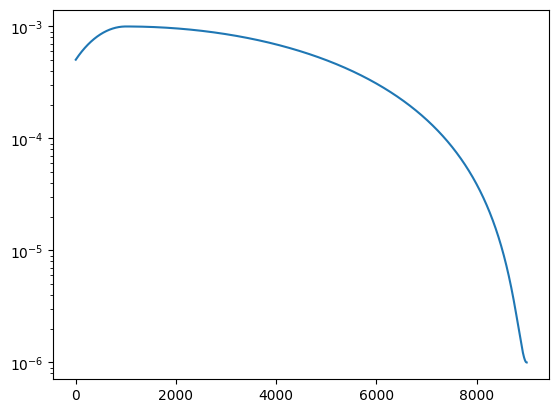

In [17]:
TOTAL_STEPS = 10000
START_LR = 1e-5
PEAK_LR = 1e-3
FINAL_LR = 1e-6
PEAK_STEP = 2000 # Absolute step where peak LR occurs

# --- Scenario 1: Starting from scratch ---
print("--- Scenario 1: Starting from Step 0 ---")
RESUME_STEP_1 = 1000
lr_scheduler_1 = CosineAnnealingWarmupRestartsResumable(
    total_steps=TOTAL_STEPS,
    start_lr=START_LR,
    peak_lr=PEAK_LR,
    final_lr=FINAL_LR,
    peak_step=PEAK_STEP,
    resume_step=RESUME_STEP_1
)
t = range(10000-RESUME_STEP_1)
plt.plot(t, lr_scheduler_1(t))
plt.yscale('log')


In [23]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np # For plotting examples

# Ensure TensorFlow version is compatible (check >= 2.x)
print(f"Using TensorFlow version: {tf.__version__}")

class FlexibleLearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Flexible Learning Rate Scheduler using dedicated functions per curve type.
    (Vectorized version compatible with array/tensor inputs)
    (Exponential functions made branchless - different behavior near zero start_lr)

    Supports different curve types ('cosine', 'linear', 'exponential', 'log')
    for the warmup (increase) and decay (decrease) phases via dedicated functions.
    Includes resumption capability via `resume_step`.
    """
    SUPPORTED_TYPES = ['cosine', 'exponential', 'linear', 'log']
    TYPE_TO_INDEX = {t: i for i, t in enumerate(SUPPORTED_TYPES)} # {'cosine': 0, ...}

    def __init__(self,
                 total_steps: int,
                 start_lr: float,
                 peak_lr: float,
                 final_lr: float,
                 peak_step: int,
                 warmup_type: str = 'cosine',
                 decay_type: str = 'cosine',
                 resume_step: int = 0,
                 name: str = None):
        """
        Initializes the scheduler. See previous version for detailed Args docstring.
        """
        super(FlexibleLearningRateScheduler, self).__init__()

        # --- Validation (omitted for brevity, same as previous version) ---
        if warmup_type.lower() not in self.SUPPORTED_TYPES or \
           decay_type.lower() not in self.SUPPORTED_TYPES:
             raise ValueError(f"Unsupported type. Supported: {self.SUPPORTED_TYPES}")
        # ... other validation ...

        self.total_steps = tf.cast(total_steps, tf.float32)
        self.start_lr = tf.cast(start_lr, tf.float32)
        self.peak_lr = tf.cast(peak_lr, tf.float32)
        self.final_lr = tf.cast(final_lr, tf.float32)
        self.peak_step = tf.cast(peak_step, tf.float32)
        self.warmup_type = warmup_type.lower()
        self.decay_type = decay_type.lower()
        self.resume_step = tf.cast(resume_step, tf.float32)
        self.pi = tf.constant(math.pi, dtype=tf.float32)
        self.epsilon = tf.constant(1e-9, dtype=tf.float32) # Lowered epsilon slightly
        self.name = name

        self.warmup_steps = tf.maximum(self.peak_step, 0.0)
        self.decay_steps = tf.maximum(self.total_steps - self.peak_step, self.epsilon)

        # Store type indices for tf.switch_case
        self.warmup_index = tf.constant(self.TYPE_TO_INDEX[self.warmup_type], dtype=tf.int32)
        self.decay_index = tf.constant(self.TYPE_TO_INDEX[self.decay_type], dtype=tf.int32)

    # --- Individual Schedule Functions ---

    def _warmup_cosine(self, progress, start_lr, end_lr):
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        return start_lr + 0.5 * (end_lr - start_lr) * (1.0 - tf.cos(self.pi * progress))

    def _decay_cosine(self, progress, start_lr, end_lr):
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        return end_lr + 0.5 * (start_lr - end_lr) * (1.0 + tf.cos(self.pi * progress))

    def _warmup_linear(self, progress, start_lr, end_lr):
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        return start_lr + (end_lr - start_lr) * progress

    def _decay_linear(self, progress, start_lr, end_lr):
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        return start_lr + (end_lr - start_lr) * progress

    def _warmup_exponential(self, progress, start_lr, end_lr):
        """ Branchless exponential warmup. Uses epsilon for stability near zero. """
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        # Use epsilon baseline for start_lr to avoid division by zero or log(0)
        s_eff = tf.maximum(start_lr, self.epsilon)
        # Use epsilon baseline for end_lr in ratio calculation if end_lr is zero
        e_eff = tf.maximum(end_lr, self.epsilon)
        ratio = e_eff / s_eff
        # Calculate: s_eff * (ratio)^progress
        # Note: If start_lr=0, this calculates epsilon * (end_lr/epsilon)^progress
        # Note: If start_lr=end_lr, ratio=1, pow=1, result=s_eff (approx start_lr)
        return s_eff * tf.pow(ratio, progress)

    def _decay_exponential(self, progress, start_lr, end_lr):
        """ Branchless exponential decay. Uses epsilon for stability near zero. """
        # Note: For decay, start_lr=peak_lr, end_lr=final_lr
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        # Use epsilon baseline for start_lr (peak_lr) if it's near zero
        s_eff = tf.maximum(start_lr, self.epsilon)
        # Use epsilon baseline for end_lr (final_lr) in ratio calculation
        e_eff = tf.maximum(end_lr, self.epsilon)
        ratio = e_eff / s_eff
        # Calculate: s_eff * (ratio)^progress
        return s_eff * tf.pow(ratio, progress)

    def _warmup_log(self, progress, start_lr, end_lr):
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        log_factor = tf.math.log1p(progress * (tf.exp(1.0) - 1.0))
        return start_lr + (end_lr - start_lr) * log_factor

    def _decay_log(self, progress, start_lr, end_lr):
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        log_factor = tf.math.log1p(progress * (tf.exp(1.0) - 1.0))
        return end_lr + (start_lr - end_lr) * (1.0 - log_factor)

    # --- Main Call Method ---
    @tf.function
    def __call__(self, step):
        """ Calculates the learning rate(s) for given step(s) since training/resumption."""
        step = tf.cast(step, dtype=tf.float32)
        effective_step = step + self.resume_step
        effective_step = tf.clip_by_value(effective_step, 0.0, self.total_steps - self.epsilon)

        is_warmup = effective_step < self.peak_step

        # --- Calculate Progress (vectorized) ---
        safe_warmup_steps = tf.maximum(self.warmup_steps, self.epsilon)
        warmup_progress = effective_step / safe_warmup_steps
        safe_decay_steps = tf.maximum(self.decay_steps, self.epsilon)
        decay_progress = (effective_step - self.peak_step) / safe_decay_steps
        progress = tf.where(is_warmup, warmup_progress, decay_progress)
        progress = tf.clip_by_value(progress, 0.0, 1.0)

        # --- Define branches for tf.switch_case ---
        warmup_branches = [
            lambda: self._warmup_cosine(progress, self.start_lr, self.peak_lr),
            lambda: self._warmup_linear(progress, self.start_lr, self.peak_lr),
            lambda: self._warmup_exponential(progress, self.start_lr, self.peak_lr), # Uses branchless version
            lambda: self._warmup_log(progress, self.start_lr, self.peak_lr),
        ]
        decay_branches = [
            lambda: self._decay_cosine(progress, self.peak_lr, self.final_lr),
            lambda: self._decay_linear(progress, self.peak_lr, self.final_lr),
            lambda: self._decay_exponential(progress, self.peak_lr, self.final_lr), # Uses branchless version
            lambda: self._decay_log(progress, self.peak_lr, self.final_lr),
        ]

        # --- Calculate potential LRs using switch_case ---
        potential_warmup_lr = tf.switch_case(
            self.warmup_index, branch_fns=warmup_branches,
            default=lambda: self._warmup_linear(progress, self.start_lr, self.peak_lr)
        )
        potential_decay_lr = tf.switch_case(
            self.decay_index, branch_fns=decay_branches,
            default=lambda: self._decay_linear(progress, self.peak_lr, self.final_lr)
        )

        # --- Select final LR using tf.where based on phase ---
        learning_rate = tf.where(is_warmup, potential_warmup_lr, potential_decay_lr)

        return learning_rate

    def get_config(self):
        """Returns the configuration of the scheduler."""
        # Config implementation omitted for brevity - same as previous version
        config = {
            "total_steps": int(self.total_steps.numpy()) if hasattr(self.total_steps, 'numpy') else int(self.total_steps),
            "start_lr": float(self.start_lr.numpy()) if hasattr(self.start_lr, 'numpy') else float(self.start_lr),
            "peak_lr": float(self.peak_lr.numpy()) if hasattr(self.peak_lr, 'numpy') else float(self.peak_lr),
            "final_lr": float(self.final_lr.numpy()) if hasattr(self.final_lr, 'numpy') else float(self.final_lr),
            "peak_step": int(self.peak_step.numpy()) if hasattr(self.peak_step, 'numpy') else int(self.peak_step),
            "warmup_type": self.warmup_type,
            "decay_type": self.decay_type,
            "resume_step": int(self.resume_step.numpy()) if hasattr(self.resume_step, 'numpy') else int(self.resume_step),
            "name": self.name,
        }
        return {k: v for k, v in config.items() if v is not None}



Using TensorFlow version: 2.10.1


Generating Plot 1: Pure Schedule Types Comparison...


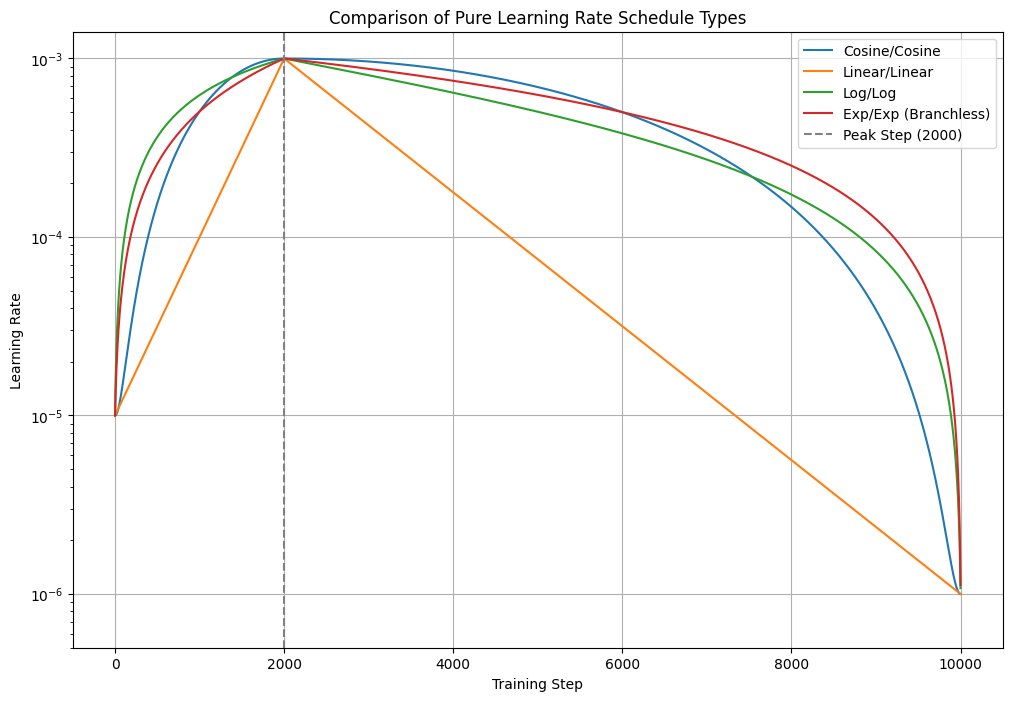


Generating Plot 2: Mixed Schedule Types Comparison...


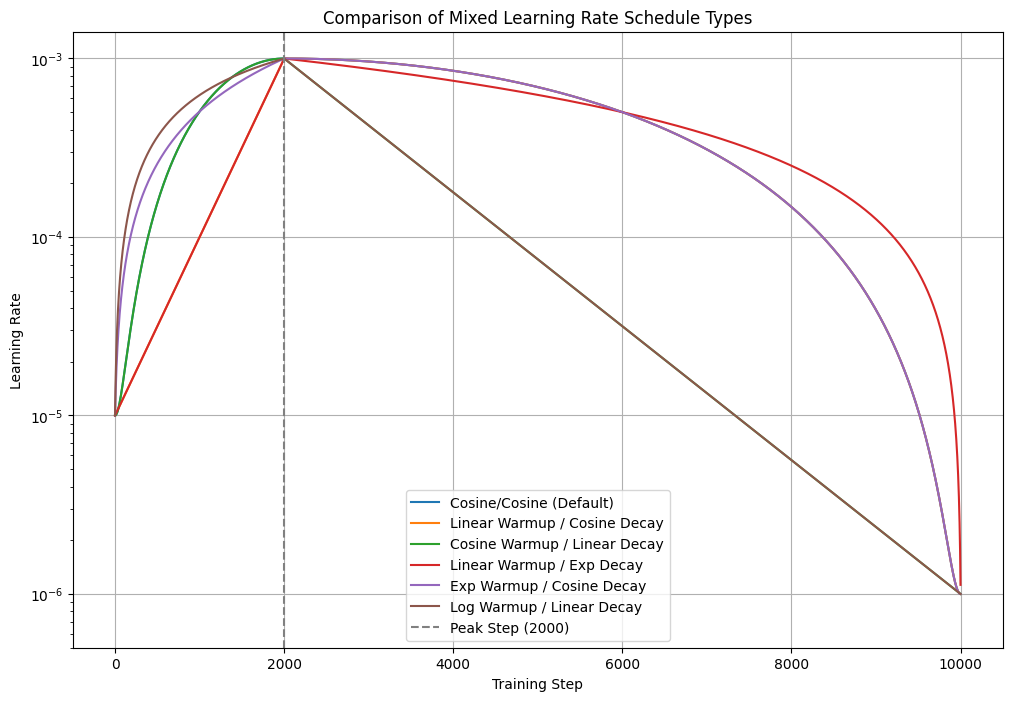


Example usage:
You can create an optimizer with any of these schedules:
Optimizer created with 'Linear Warmup / Exp Decay' schedule.
LR at step 5000: 6.253750e-04


In [24]:

# Ensure the FlexibleLearningRateScheduler class definition from the
# previous response is available here.

# --- Example Parameters ---
TOTAL_STEPS = 10000
START_LR = 1e-5   # Use a non-zero start LR for general examples
PEAK_LR = 1e-3
FINAL_LR = 1e-6
PEAK_STEP = 2000
RESUME_STEP = 0

# --- Generate Steps for Plotting ---
steps_plot = np.arange(TOTAL_STEPS)
steps_tensor = tf.constant(steps_plot, dtype=tf.float32) # Use Tensor input

# --- Plot 1: Comparison of Pure Schedule Types ---

print("Generating Plot 1: Pure Schedule Types Comparison...")

schedules_pure = {
    "Cosine/Cosine": FlexibleLearningRateScheduler(
        total_steps=TOTAL_STEPS, start_lr=START_LR, peak_lr=PEAK_LR, final_lr=FINAL_LR,
        peak_step=PEAK_STEP, warmup_type='cosine', decay_type='cosine', resume_step=RESUME_STEP
    ),
    "Linear/Linear": FlexibleLearningRateScheduler(
        total_steps=TOTAL_STEPS, start_lr=START_LR, peak_lr=PEAK_LR, final_lr=FINAL_LR,
        peak_step=PEAK_STEP, warmup_type='linear', decay_type='linear', resume_step=RESUME_STEP
    ),
    "Log/Log": FlexibleLearningRateScheduler(
        total_steps=TOTAL_STEPS, start_lr=START_LR, peak_lr=PEAK_LR, final_lr=FINAL_LR,
        peak_step=PEAK_STEP, warmup_type='log', decay_type='log', resume_step=RESUME_STEP
    ),
    "Exp/Exp (Branchless)": FlexibleLearningRateScheduler(
        total_steps=TOTAL_STEPS, start_lr=START_LR, peak_lr=PEAK_LR, final_lr=FINAL_LR,
        peak_step=PEAK_STEP, warmup_type='exponential', decay_type='exponential', resume_step=RESUME_STEP
    ),
}

plt.figure(figsize=(12, 8))
for name, scheduler in schedules_pure.items():
    lrs = scheduler(steps_tensor).numpy()
    plt.plot(steps_plot, lrs, label=name)

plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.title("Comparison of Pure Learning Rate Schedule Types")
plt.axvline(PEAK_STEP, color='grey', linestyle='--', label=f'Peak Step ({PEAK_STEP})')
plt.legend()
plt.grid(True)
plt.yscale('log') # Log scale is helpful for LR visualization
plt.ylim(bottom=FINAL_LR / 2)
plt.show()

# --- Plot 2: Comparison of Mixed Schedule Types ---

print("\nGenerating Plot 2: Mixed Schedule Types Comparison...")

schedules_mixed = {
    "Cosine/Cosine (Default)": schedules_pure["Cosine/Cosine"], # Reuse from above
    "Linear Warmup / Cosine Decay": FlexibleLearningRateScheduler(
        total_steps=TOTAL_STEPS, start_lr=START_LR, peak_lr=PEAK_LR, final_lr=FINAL_LR,
        peak_step=PEAK_STEP, warmup_type='linear', decay_type='cosine', resume_step=RESUME_STEP
    ),
    "Cosine Warmup / Linear Decay": FlexibleLearningRateScheduler(
        total_steps=TOTAL_STEPS, start_lr=START_LR, peak_lr=PEAK_LR, final_lr=FINAL_LR,
        peak_step=PEAK_STEP, warmup_type='cosine', decay_type='linear', resume_step=RESUME_STEP
    ),
    "Linear Warmup / Exp Decay": FlexibleLearningRateScheduler(
        total_steps=TOTAL_STEPS, start_lr=START_LR, peak_lr=PEAK_LR, final_lr=FINAL_LR,
        peak_step=PEAK_STEP, warmup_type='linear', decay_type='exponential', resume_step=RESUME_STEP
    ),
     "Exp Warmup / Cosine Decay": FlexibleLearningRateScheduler(
        total_steps=TOTAL_STEPS, start_lr=START_LR, peak_lr=PEAK_LR, final_lr=FINAL_LR,
        peak_step=PEAK_STEP, warmup_type='exponential', decay_type='cosine', resume_step=RESUME_STEP
    ),
    "Log Warmup / Linear Decay": FlexibleLearningRateScheduler(
        total_steps=TOTAL_STEPS, start_lr=START_LR, peak_lr=PEAK_LR, final_lr=FINAL_LR,
        peak_step=PEAK_STEP, warmup_type='log', decay_type='linear', resume_step=RESUME_STEP
    ),
}

plt.figure(figsize=(12, 8))
for name, scheduler in schedules_mixed.items():
    lrs = scheduler(steps_tensor).numpy()
    plt.plot(steps_plot, lrs, label=name)

plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.title("Comparison of Mixed Learning Rate Schedule Types")
plt.axvline(PEAK_STEP, color='grey', linestyle='--', label=f'Peak Step ({PEAK_STEP})')
plt.legend()
plt.grid(True)
plt.yscale('log') # Log scale is helpful for LR visualization
plt.ylim(bottom=FINAL_LR / 2)
plt.show()

print("\nExample usage:")
print("You can create an optimizer with any of these schedules:")
optimizer = tf.keras.optimizers.Adam(
    learning_rate=schedules_mixed["Linear Warmup / Exp Decay"]
)
print("Optimizer created with 'Linear Warmup / Exp Decay' schedule.")
# Example of getting LR at a specific step
step_example = tf.constant(5000, dtype=tf.float32)
lr_at_step = schedules_mixed["Linear Warmup / Exp Decay"](step_example)
print(f"LR at step {int(step_example.numpy())}: {lr_at_step.numpy():.6e}")